In [1]:
import numpy as np
import sys
import json
import time
import datetime

import scipy.io
import scipy.ndimage as snd
from scipy.stats import moment
from scipy.optimize import curve_fit

from epics import caget, caput

from image import Image
from emittance_calc import get_normemit, mkdir_p

import matplotlib.pyplot as plt

In [2]:
!pwd

/home/physics/smiskov/lcls_emit


In [8]:
#caget("OTRS:IN20:571:RESOLUTION") 12.23

cannot connect to OTRS:IN20:571:RESOLUTION


In [2]:
# get PV info
pv_info = json.load(open('pv_info.json'))

im_pv = "OTRS:IN20:571:IMAGE"
n_col_pv = "OTRS:IN20:571:ROI_YNP"
n_row_pv = "OTRS:IN20:571:ROI_XNP"

meas_input = pv_info['device']['QUAD']['Q525']
quad_act = "QUAD:IN20:525:BACT"
varx_pv = pv_info['device']['SOL']['SOL121']
vary_pv = pv_info['device']['QUAD']['Q121']
varz_pv = pv_info['device']['QUAD']['Q122']

x_size_pv = pv_info['device']['OTR2']['profmonxsize']
y_size_pv = pv_info['device']['OTR2']['profmonysize']

energy = caget(pv_info['energy']['DL1'])
resolution = 12.23*1e-6


In [12]:
# change quad function
def setquad(value):
    """Sets Q525 to new scan value"""
    caput(meas_input, value)
    
def saveimage(im, ncol, nrow, beamsizes):
    mkdir_p("saved_images")
    timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
    np.save(f'./saved_images/img_{timestamp}.npy', im)
    np.save(f'./saved_images/ncol_{timestamp}.npy', ncol)
    np.save(f'./saved_images/nrow_{timestamp}.npy', nrow)
    
    f= open(f"image_acq_quad_info.csv", "a+")
    bact = caget(quad_act)
    x_size = caget(x_size_pv)
    y_size = caget(y_size_pv)
    f.write(f"{timestamp},{ncol},{nrow},{resolution},{bact},{x_size},{y_size},{beamsizes[0]},{beamsizes[1]}\n")
    f.close()
    
def getbeamsizes(avg_num_images=1):
    """Returns xrms, yrms, xrms_err, yrms_err"""
    im = caget(im_pv)
    # average multiple images to obtain final image
    if avg_num_images>1:
        for i in range(avg_num_images):
            im_tmp = caget(im_pv)
            im = np.mean(np.array([ im,im_tmp ]), axis=0 )
        
    ncol, nrow = caget(n_col_pv), caget(n_row_pv)
    
    beam_image = Image(im, ncol, nrow, bg_image = None)
    beam_image.reshape_im()
    beam_image.subtract_bg()
    beam_image.proc_image = beam_image.proc_image[200:900, 1000:]
    beam_image.get_im_projection()
    plt.imshow(beam_image.proc_image)
    beamsizes = beam_image.get_sizes(show_plots=False)[0:2]
     
    # Here    
    saveimage(im, ncol, nrow, np.array(beamsizes)*resolution/1e-6) # pass beamsizes in um
    return beamsizes 

def get_updated_beamsizes(quad):
    """Get size should take a quad B field in kG and return [xrms, yrms] in meters"""
    # uncomment here 
#     setquad(quad)
#     time.sleep(3)
    # here
    beamsizes = np.array(getbeamsizes())[0:2]*resolution # convert to meters
    xrms = beamsizes[0]
    yrms = beamsizes[1]
    return xrms, yrms

In [5]:
pvname_list = ['SOLN:IN20:121:BCTRL', #solenoid
               'QUAD:IN20:121:BCTRL', #skew quad
               'QUAD:IN20:122:BCTRL' #skew quad
              ]

In [6]:
# init vals
init_sol  = caget(pvname_list[0])
init_q121 = caget(pvname_list[1])
init_q122 = caget(pvname_list[2])
print(init_sol, init_q121, init_q122)

0.4695 0.015 0.0117


In [8]:
def set_injector(varx, vary, varz):
    caput(pvname_list[0], varx)
    caput(pvname_list[1], vary)
    caput(pvname_list[2], vary)

In [9]:
# example init quad list
quad_list = [-5, -4, -3, -2]
xrms = []
yrms = []

for quad in quad_list:
#     setquad(quad)
#     time.sleep(3)
    beamsizes = getbeamsizes()[0:2]*resolution #convert to meters
    xrms.append(beamsizes[0])
    yrms.append(beamsizes[1])

# # Compute and return emittance using quad_list and beamsizes_list
# emittance = get_normemit(0.135, quad, quad, xrms, yrms, adapt_ranges=True, num_points=5, show_plots=True)
# print(emittance)

cannot connect to OTRS:IN20:571:IMAGE
cannot connect to OTRS:IN20:571:ROI_YNP


KeyboardInterrupt: 

In [11]:
caget("OTRS:IN20:571:IMAGE")

array([ 7,  7,  7, ..., 10, 11,  6], dtype=int32)

In [ ]:
pv = epics.PV('OTRS:IN20:571:IMAGE')
pv.get()

(0.035072490199929335, 8.335667204896213)

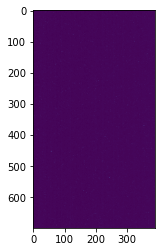

In [13]:
getbeamsizes()